**1. Exploratory data analysis**

Let's install librosa using the pip package. This will ensure that all required dependencies are installed. 

In [1]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!dir

sample_data


In [4]:
!pwd

/content


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [6]:
!kaggle datasets download -d chrisfilo/urbansound8k

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.9/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.9/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /content. Or use the environment method.


In [7]:
!unzip urbansound8k.zip

unzip:  cannot find or open urbansound8k.zip, urbansound8k.zip.zip or urbansound8k.zip.ZIP.


**Loading the wav**

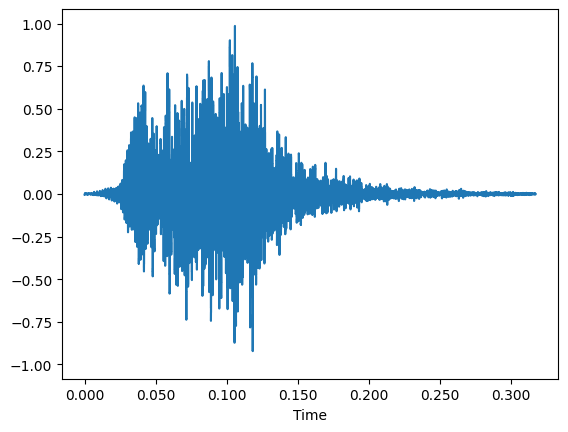

In [3]:
file_name='/content/100032-3-0-0.wav'

audio_data, sampling_rate = librosa.load(file_name)
librosa.display.waveshow(audio_data,sr=sampling_rate)
ipd.Audio(file_name)

In [11]:
audio_data

array([-0.00347107, -0.00501926, -0.00465449, ..., -0.00248442,
       -0.00154777, -0.00035547], dtype=float32)

In mono, there is only one signal. So, the results from our audio_data show that librosa has converted the audio into integers with only 1-dimension.

In [12]:
sampling_rate

22050

Librosa is an open-source python package for music and audio analysis. The library is able to give us the data and the sampling rate. By default, librosa mixes all audio to mono and resamples them to 22050 Hz at load time. This plays a very important role as in audio, different sounds have different sample rates.

Let's use the Pandas library to read our csv file



In [4]:
audio_dataset_path='/content/'
metadata=pd.read_csv('UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Let's check whether the dataset is imbalanced

In [5]:
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

Most of the classes in the dataset are balanced. Thus, this would be a good dataset to use.

**2. Data preprocessing**

To extract the features, we will be using the Mel-Frequency Cepstral Coefficients (MFCC) algorithm. This algorithm summarizes the frequency distribution across the window size. This enables the analysis of both the frequency and time characteristics of the sound. It will enable us identify features for classification.

In [6]:
mfccs = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=40)

In [16]:
mfccs

array([[-3.32038788e+02, -1.69587753e+02, -9.02468262e+01,
        -5.69234695e+01, -4.02758827e+01, -5.05441818e+01,
        -9.92239380e+01, -1.59670334e+02, -2.15643402e+02,
        -2.67756226e+02, -3.16286255e+02, -3.55396240e+02,
        -3.90084351e+02, -4.23439941e+02],
       [ 1.19396584e+02,  8.32950592e+01,  6.16887207e+01,
         4.81857071e+01,  3.91407013e+01,  3.40161896e+01,
         3.07527199e+01,  3.43890457e+01,  4.42340240e+01,
         5.63340034e+01,  6.82769012e+01,  7.86100235e+01,
         8.57964630e+01,  9.20208588e+01],
       [-1.02875778e+02, -1.20093826e+02, -1.29499573e+02,
        -1.37105560e+02, -1.43409180e+02, -1.45280518e+02,
        -1.39969147e+02, -1.29590729e+02, -1.26099014e+02,
        -1.23362244e+02, -1.14323456e+02, -1.10078384e+02,
        -1.04549728e+02, -9.31469727e+01],
       [-5.25918312e+01, -6.20533218e+01, -7.39054718e+01,
        -7.90486221e+01, -7.57979813e+01, -7.48995667e+01,
        -7.34803467e+01, -6.70451965e+01, -6.

These are patterns that have been extracted from the audio based on the frequency and time characteristics.

In [7]:
def features_extractor(file):
    audio, sample_rate = librosa.load("/content/100032-3-0-0.wav", res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [ ]:
pip install resampy

In [8]:
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor("/content/100032-3-0-0.wav")
    extracted_features.append([data,final_class_labels])

8732it [02:54, 50.15it/s]


Let's convert the entire list into a dataframe using the Pandas library.

In [9]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head(10)

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-217.35526, 70.22338, -130.38527, -53.282898,...",children_playing
2,"[-217.35526, 70.22338, -130.38527, -53.282898,...",children_playing
3,"[-217.35526, 70.22338, -130.38527, -53.282898,...",children_playing
4,"[-217.35526, 70.22338, -130.38527, -53.282898,...",children_playing
5,"[-217.35526, 70.22338, -130.38527, -53.282898,...",children_playing
6,"[-217.35526, 70.22338, -130.38527, -53.282898,...",children_playing
7,"[-217.35526, 70.22338, -130.38527, -53.282898,...",children_playing
8,"[-217.35526, 70.22338, -130.38527, -53.282898,...",children_playing
9,"[-217.35526, 70.22338, -130.38527, -53.282898,...",car_horn


We now split the dataset into independent and dependent dataset

In [10]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape

In [ ]:
y

In [ ]:
y.shape

In [11]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [25]:
import pickle
with open('labelencode.pickle','wb') as f:
  pickle.dump(labelencoder,f)

labelencoder

LabelEncoder()

In [ ]:
y

In [ ]:
y.shape

We perform a train test split

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

**3. Model creation**

In [13]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [16]:
num_labels=y.shape[1]

In [17]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               4100      
                                                                 
 activation_3 (Activation)   (None, 100)               0         
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 200)               20200     
                                                                 
 activation_4 (Activation)   (None, 200)               0         
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 100)              

In [19]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 24: val_loss did not improve from 2.26840
219/219 [==============================] - 1s 5ms/step - loss: 2.2563 - accuracy: 0.1137 - val_loss: 2.2696 - val_accuracy: 0.1042
Epoch 25/200
201/219 [==========================>...] - ETA: 0s - loss: 2.2558 - accuracy: 0.1183
Epoch 25: val_loss did not improve from 2.26840
219/219 [==============================] - 1s 3ms/step - loss: 2.2562 - accuracy: 0.1174 - val_loss: 2.2696 - val_accuracy: 0.1048
Epoch 26/200
217/219 [============================>.] - ETA: 0s - loss: 2.2567 - accuracy: 0.1130
Epoch 26: val_loss did not improve from 2.26840
219/219 [==============================] - 1s 3ms/step - loss: 2.2563 - accuracy: 0.1128 - val_loss: 2.2697 - val_accuracy: 0.1042
Epoch 27/200
212/219 [============================>.] - ETA: 0s - loss: 2.2562 - accuracy: 0.1106
Epoch 27: val_loss did not improve from 2.26840
219/219 [==============================] - 1s 4ms/step - loss: 2.2561 - accuracy: 0.1114 - val_loss: 2.2698 - val_accura

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

In [21]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

55/55 [==============================] - 0s 1ms/step


In [ ]:
predict_x

In [ ]:
classes_x

array([5, 3, 4, ..., 1, 9, 0])

In [30]:
! zip -r audio_classification.zip audio_classification

  adding: audio_classification/ (stored 0%)
  adding: audio_classification/keras_metadata.pb (deflated 90%)
  adding: audio_classification/saved_model.pb (deflated 89%)
  adding: audio_classification/variables/ (stored 0%)
  adding: audio_classification/variables/variables.data-00000-of-00001 (deflated 27%)
  adding: audio_classification/variables/variables.index (deflated 61%)
  adding: audio_classification/assets/ (stored 0%)
  adding: audio_classification/fingerprint.pb (stored 0%)


In [26]:
model.save("audio_classification")

**4. Testing the model**

In [ ]:
filename="fold8/103076-3-0-0.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
print(predicted_label)
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = labelencoder.inverse_transform(classes_x)
prediction_class

[-4.3655270e+02  5.9230797e+01 -4.3656607e+00 -1.8696339e+01
 -2.1808062e+01 -2.1441746e+01 -2.0656868e+01 -1.0533067e+01
 -1.0726240e+01  1.1780758e+00  2.9764354e+00  1.8751724e+00
  1.1146365e+00  3.6338196e+00  5.0674267e+00  1.7557142e+00
 -3.5938418e+00 -3.6886477e+00 -6.2886648e+00 -8.8013878e+00
 -8.1570635e+00 -4.9429231e+00 -1.7873219e+00  2.0938160e+00
  2.1526849e+00 -4.7784606e-01 -2.7652733e+00 -3.8324444e+00
 -3.7962842e+00 -4.3711638e+00 -2.7436407e+00  1.5701178e-01
 -2.4533394e-01  7.0105374e-01  1.4864315e+00  1.7523667e+00
  1.7043139e+00  4.5822546e-01  5.2978408e-01 -1.0451510e+00]
[[-4.3655270e+02  5.9230797e+01 -4.3656607e+00 -1.8696339e+01
  -2.1808062e+01 -2.1441746e+01 -2.0656868e+01 -1.0533067e+01
  -1.0726240e+01  1.1780758e+00  2.9764354e+00  1.8751724e+00
   1.1146365e+00  3.6338196e+00  5.0674267e+00  1.7557142e+00
  -3.5938418e+00 -3.6886477e+00 -6.2886648e+00 -8.8013878e+00
  -8.1570635e+00 -4.9429231e+00 -1.7873219e+00  2.0938160e+00
   2.1526849e+00 

array(['dog_bark'], dtype='<U16')